In [ ]:
!nvidia-smi

Mon May 16 07:17:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import library

In [ ]:
from PIL import Image
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import random
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Get Data

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 145 kB 73.2 MB/s 
     |████████████████████████████████| 181 kB 78.7 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=684419a1c4fe3be0d950c8b850b1c1c7e5e079df3d3387faf8d3a31f4acb3d15
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
Mounted at /content/gdrive/


In [ ]:
from glob import glob
train_file = glob(f'/content/gdrive/MyDrive/Colab Notebooks/maps/train/*')
val_file = glob(f'/content/gdrive/MyDrive/Colab Notebooks/maps/val/*')

# Dataset Functions

In [ ]:
def splitTensor(sample):
        C, H, W = sample.shape
        
        input_image = sample[:,:,:int(W/2)]
        target_image = sample[:,:,int(W/2):]
        
        output = torch.cat([input_image,target_image])
        return output

In [ ]:
def make_two_tensor(sample):
  C, H, W = sample.shape   
  input_image = sample[:int(C/2),:,:]
  target_image = sample[int(C/2):,:,:] 

  return input_image, target_image

In [ ]:
def split_input_tensor(sample):
  C, H, W = sample.shape
        
  input_image = sample[:,:,:int(W/2)]
  target_image = sample[:,:,int(W/2):]
  
  output = torch.cat([input_image,target_image])

  return input_image, target_image

In [ ]:
def file_to_PIL(sample):
  
  result = Image.open(sample)

  return result

In [ ]:
def unnormalize(sample):
  sample = ((sample * 0.5) + 0.5)
  return sample

In [ ]:
def shuffle_batch(data):
  data_len = len(data)
  data_index = random.sample(range(data_len), data_len)
  data = data[data_index]
  return data

In [ ]:
def tensor_to_image(data):
  return  unnormalize(np.transpose(data.detach().cpu().numpy()[0] , (1, 2, 0)))

# Dataset

In [ ]:
image_height = 256
image_width = 256

In [ ]:
class CustomDatasest(Dataset):
  def __init__(self, np_data, transform = None):
      self.data = np_data
      self.transform = transform
      self.len = len(np_data)

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    sample = self.data[idx]
    if self.transform:
      sample = self.transform(sample)
    return sample

In [ ]:
trans = transforms.Compose([
                            file_to_PIL,
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                            transforms.Resize((image_height, image_width * 2)),
                            splitTensor,
                            transforms.RandomHorizontalFlip(),
                            make_two_tensor,
                            ])

#TMP_loader

In [ ]:
tmp = val_file[:64]
tmp_set = CustomDatasest(tmp, transform = trans)
tmp_loader = DataLoader(
    dataset = tmp_set, 
    batch_size = 2,
    shuffle=True
)

In [ ]:
dataiter = iter(tmp_loader)

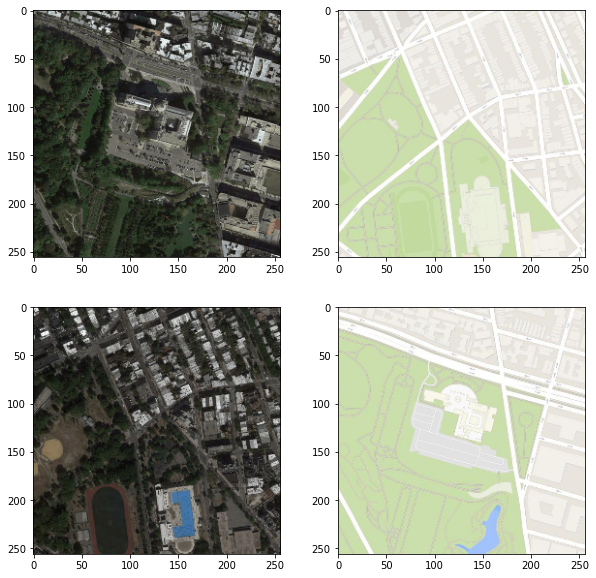

In [ ]:
a, b = next(dataiter)

b = shuffle_batch(b)

fig = plt.figure(figsize=(10,10))
fig.add_subplot(221)
plt.imshow(unnormalize(np.transpose(a.detach().cpu().numpy()[0] , (1, 2, 0))) )
fig.add_subplot(222)
plt.imshow(unnormalize(np.transpose(b.detach().cpu().numpy()[0] , (1, 2, 0)))  )
fig.add_subplot(223)
plt.imshow(unnormalize(np.transpose(a.detach().cpu().numpy()[1], (1, 2, 0)))  )
fig.add_subplot(224)
plt.imshow(unnormalize(np.transpose(b.detach().cpu().numpy()[1] , (1, 2, 0)))  )
plt.show()

#parameter

In [ ]:
from tqdm import tqdm
from pytz import timezone
from datetime import datetime
now = datetime.now(timezone('Asia/Seoul'))
print(now)
BATCHSIZE = 1
EPOCHS = 200
lr = 0.0002

load_model = False
load_model_fileName = f''

wandb_resume = '' # If you want resume wandb, put project key

save_model = True
model_save_epoch = 10
model_root_folder = f'/content/gdrive/MyDrive/Colab Notebooks/maps/cyclegan_resnet_semi/'
save_model_fileName = f'semi_cyclegan_model_{now}.pth'
save_model_path = model_root_folder + save_model_fileName
load_model_file = model_root_folder + load_model_file_name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2022-05-16 16:17:46.730344+09:00


# Data Loader

In [ ]:
custom_train_set = CustomDatasest(train_file, transform = trans)
custom_test_set = CustomDatasest(val_file, transform = trans)
train_loader = DataLoader(
    dataset = custom_train_set, 
    batch_size = BATCHSIZE,
    shuffle=True
)

test_loader = DataLoader(
    dataset = custom_test_set, 
    batch_size = BATCHSIZE
)

#Model 구조 선언

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.Dropout(0.2),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

##Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, input_nc):
      super(Discriminator, self).__init__()

      # A bunch of convolutions one after another
      model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                  nn.LeakyReLU(0.2, inplace=True),
                  nn.Dropout(0.2)]

      model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                  nn.InstanceNorm2d(128),
                  nn.LeakyReLU(0.2, inplace=True),
                  nn.Dropout(0.2) ]

      model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                  nn.InstanceNorm2d(256),
                  nn.LeakyReLU(0.2, inplace=True),
                  nn.Dropout(0.2)]

      model += [  nn.Conv2d(256, 512, 4, 1, 1),
                  nn.InstanceNorm2d(512),
                  nn.LeakyReLU(0.2, inplace=True) ]

      # FCN classification layer
      model += [nn.Conv2d(512, 1, 4, 1, 1)]

      self.model = nn.Sequential(*model)

  def forward(self, x):
    return self.model(x)

## ReplayBuffer

In [ ]:
from torch.autograd import Variable
import random

class ReplayBuffer():
    def __init__(self, max_size=16):
        assert (max_size > 0),
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.)

# Model 선언

In [ ]:
netG_A2B = Generator(3, 3)
netG_B2A = Generator(3, 3)
netD_A = Discriminator(3)
netD_B = Discriminator(3)

netG_A2B.to(device)
netG_B2A.to(device)
netD_A.to(device)
netD_B.to(device)

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Loss Functions & optimizer

In [ ]:
# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()
criterion_sv = torch.nn.L1Loss()

# Optimizers & LR schedulers
g_parameters = list(netG_A2B.parameters()) + list(netG_B2A.parameters())
optimizer_G = torch.optim.Adam(g_parameters,
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda epoch: 0.95 ** epoch,last_epoch=-1,verbose=False)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda epoch: 0.95 ** epoch,last_epoch=-1,verbose=False)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda epoch: 0.95 ** epoch,last_epoch=-1,verbose=False)

#Load Model

In [ ]:
start_epoch = 1
if load_model :
  checkpoint = torch.load(load_model_file, map_location=torch.device('cpu'))
  lr = checkpoint['lr']
  start_epoch = checkpoint['epoch']
  netG_A2B.load_state_dict(checkpoint['netG_A2B_state_dict'])
  netG_B2A.load_state_dict(checkpoint['netG_B2A_state_dict'])
  netD_A.load_state_dict(checkpoint['netD_A_state_dict'])
  netD_B.load_state_dict(checkpoint['netD_B_state_dict'])
  optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
  optimizer_D_A.load_state_dict(checkpoint['optimizer_D_A_state_dict'])
  optimizer_D_B.load_state_dict(checkpoint['optimizer_D_B_state_dict'])
  lr_scheduler_G.load_state_dict(checkpoint['lr_scheduler_G_state_dict'])
  lr_scheduler_D_A.load_state_dict(checkpoint['lr_scheduler_D_A_state_dict'])
  lr_scheduler_D_B.load_state_dict(checkpoint['lr_scheduler_D_B_state_dict'])
print(start_epoch)

# Test GAN

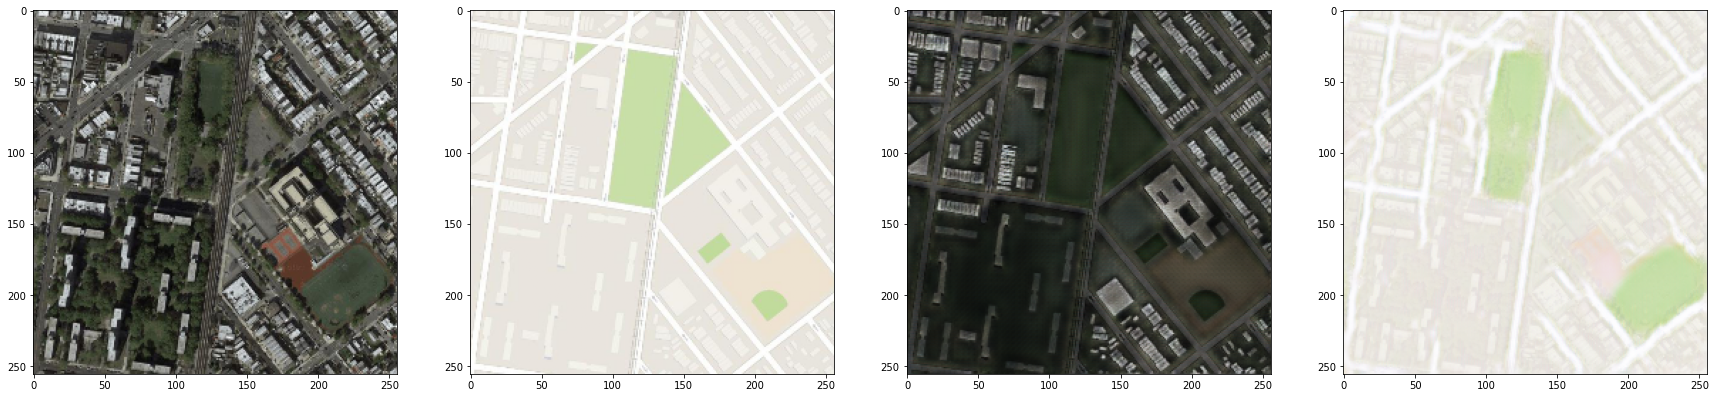

In [ ]:
dataiter = iter(tmp_loader)
a, b = next(dataiter)

netG_A2B.to(device)
netG_B2A.to(device)
netG_A2B.eval()
netG_B2A.eval()

with torch.no_grad():
  inputA = a[1].unsqueeze(dim=0).to(device)
  inputB = b[1].unsqueeze(dim=0).to(device)

  fake_A = netG_B2A(inputB)
  fake_B = netG_A2B(inputA)
  tmp_fake_A = unnormalize(np.transpose(fake_A.detach().cpu().numpy()[0] , (1, 2, 0)))
  tmp_fake_B = unnormalize(np.transpose(fake_B.detach().cpu().numpy()[0] , (1, 2, 0)))
  tmp_input_A = unnormalize(np.transpose(inputA.detach().cpu().numpy()[0] , (1, 2, 0)))
  tmp_input_B = unnormalize(np.transpose(inputB.detach().cpu().numpy()[0] , (1, 2, 0)))


  fig = plt.figure(figsize=(30,30))
  fig.add_subplot(141)
  plt.imshow(tmp_input_A)
  fig.add_subplot(142)
  plt.imshow(tmp_input_B)
  fig.add_subplot(143)
  plt.imshow(tmp_fake_A)
  fig.add_subplot(144)
  plt.imshow(tmp_fake_B)
  plt.show()

#wandb 설정

In [ ]:
!pip install wandb
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
config = {
  "learning_rate": lr,
  "epochs": EPOCHS,
  "batch_size": BATCHSIZE
}

wandb.init(project="Semi Cyclegan ResNet", resume = wandb_resume)
if not wandb.run.resumed:
  wandb.run.name = 'Date : '+str(now)
wandb.config.update(config)

wandb: Currently logged in as: nek0. Use `wandb login --relogin` to force relogin


In [ ]:
wandb.run.name, wandb.run.resumed

('Date : 2022-05-15 21:00:18.460068+09:00', True)

#Train

In [ ]:
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [ ]:
!nvidia-smi

Sun May 15 12:00:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    34W / 250W |   1117MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
iter_num = int(len(train_loader.dataset) / BATCHSIZE)
###################################
netG_A2B.train()
netG_B2A.train()
netD_A.train()
netD_B.train()

netG_A2B.to(device)
netG_B2A.to(device)
netD_A.to(device)
netD_B.to(device)

###### Training ######
for epoch in range(start_epoch, EPOCHS+1):
  progress_bar = tqdm(range(iter_num))

  stack_A = []
  stack_B  = []
  train_iter = iter(train_loader)
  image_data_A, image_data_B = next(train_iter)
  stack_A.append(image_data_A)
  stack_B.append(image_data_B)
  first_B = image_data_B

  loss_G_sum = 0
  loss_identity_A_sum = 0
  loss_identity_B_sum = 0
  loss_GAN_A2B_sum = 0
  loss_GAN_B2A_sum = 0
  loss_cycle_ABA_sum = 0
  loss_cycle_BAB_sum = 0
  loss_D_A_sum = 0
  loss_D_B_sum = 0
  loss_sv_sum = 0
  loss_sv_G_A2B_sum = 0
  loss_sv_G_B2A_sum = 0

  for i in progress_bar:
      # Set model input
      image_data_A = stack_A.pop()
      image_data_B = stack_B.pop()

      ############ Supervised Learning ############

      real_A = image_data_A.to(device)
      real_B = image_data_B.to(device)

      optimizer_G.zero_grad()

      ###### Generators A2B ######
      fake_B = netG_A2B(real_A)
      cycled_A = netG_B2A(fake_B)

      loss_l1_sv_A2B = criterion_sv(fake_B, real_B) * 10.
      loss_cycle_sv_ABA = criterion_sv(cycled_A, real_A) * 10.
      loss_sv_G_A2B = loss_l1_sv_A2B + loss_cycle_sv_ABA
      loss_sv_G_A2B.backward()

      
      ###### Generators B2A ######
      fake_A = netG_B2A(real_B)
      cycled_B = netG_A2B(fake_A)

      loss_l1_sv_B2A = criterion_sv(fake_A, real_A) * 10.
      loss_cycle_sv_BAB = criterion_sv(cycled_B, real_B) * 10.
      loss_sv_G_B2A = loss_l1_sv_B2A + loss_cycle_sv_BAB
      loss_sv_G_B2A.backward()

      optimizer_G.step()


      ############ Unsupervised Learning ############
      if (i+1) == iter_num:
        real_B = first_B.to(device)
      else:
        next_data_A, next_data_B = next(train_iter)
        stack_A.append(next_data_A)
        stack_B.append(next_data_B)
        real_B = next_data_B.to(device)

      ###### Generators A2B and B2A ######
      optimizer_G.zero_grad()

      # Identity loss
      same_B = netG_A2B(real_B)
      loss_identity_B = criterion_identity(same_B, real_B)*10.0
      loss_identity_B.backward()

      same_A = netG_B2A(real_A)
      loss_identity_A = criterion_identity(same_A, real_A)*10.0
      loss_identity_A.backward()

      # GAN loss
      fake_B = netG_A2B(real_A)
      pred_fake = netD_B(fake_B)

      target_real = torch.ones_like(pred_fake.detach(), requires_grad=False).to(device)
      target_fake = torch.zeros_like(pred_fake.detach(), requires_grad=False).to(device)

      loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

      recovered_A = netG_B2A(fake_B)
      loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0
      
      fake_loss_A2B = loss_GAN_A2B + loss_cycle_ABA
      fake_loss_A2B.backward()

      fake_A = netG_B2A(real_B)
      pred_fake = netD_A(fake_A)
      loss_GAN_B2A = criterion_GAN(pred_fake, target_real)
      
      recovered_B = netG_A2B(fake_A)
      loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0
      
      fake_loss_B2A = loss_GAN_B2A + loss_cycle_BAB
      fake_loss_B2A.backward()
      
      optimizer_G.step()
      # Total loss
      loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
      ###################################

      ###### Discriminator A ######
      optimizer_D_A.zero_grad()

      # Real loss
      pred_real = netD_A(real_A)
      loss_D_real = criterion_GAN(pred_real, target_real)

      # Fake loss
      fake_A = fake_A_buffer.push_and_pop(fake_A)
      pred_fake = netD_A(fake_A.detach())
      loss_D_fake = criterion_GAN(pred_fake, target_fake)

      # Total loss
      loss_D_A = (loss_D_real + loss_D_fake)*0.5
      loss_D_A.backward()

      optimizer_D_A.step()
      ###################################

      ###### Discriminator B ######
      optimizer_D_B.zero_grad()

      # Real loss
      pred_real = netD_B(real_B)
      loss_D_real = criterion_GAN(pred_real, target_real)
      
      # Fake loss
      fake_B = fake_B_buffer.push_and_pop(fake_B)
      pred_fake = netD_B(fake_B.detach())
      loss_D_fake = criterion_GAN(pred_fake, target_fake)

      # Total loss
      loss_D_B = (loss_D_real + loss_D_fake)*0.5
      loss_D_B.backward()

      optimizer_D_B.step()
      ###################################
      loss_G_sum += loss_G.item()
      loss_identity_A_sum += loss_identity_A.item()
      loss_identity_B_sum += loss_identity_B.item()
      loss_GAN_A2B_sum += loss_GAN_A2B.item()
      loss_GAN_B2A_sum += loss_GAN_B2A.item()
      loss_cycle_ABA_sum += loss_cycle_ABA.item()
      loss_cycle_BAB_sum += loss_cycle_BAB.item()
      loss_D_A_sum += loss_D_A.item()
      loss_D_B_sum += loss_D_B.item()
      loss_sv_G_A2B_sum += loss_sv_G_A2B.item()
      loss_sv_G_B2A_sum += loss_sv_G_B2A.item()

    # Update learning rates
  print('Epoch [{}/{}]' 
      .format(epoch, EPOCHS))
  lr_scheduler_G.step()
  lr_scheduler_D_A.step()
  lr_scheduler_D_B.step()

  with torch.no_grad():
    tmp_A = image_data_A.to(device)
    tmp_B = image_data_B.to(device)
    tmp_fake_A = netG_B2A(tmp_B)
    tmp_fake_B = netG_A2B(tmp_A)
    tmp_cycled_A = netG_B2A(tmp_fake_B)
    tmp_cycled_B = netG_A2B(tmp_fake_A)

    wandb.log({
        "Input Image A": wandb.Image(tensor_to_image(tmp_A)),
        "Input Image B": wandb.Image(tensor_to_image(tmp_B)),
        "Generate Image A": wandb.Image(tensor_to_image(tmp_fake_A)),
        "Generate Image B": wandb.Image(tensor_to_image(tmp_fake_B)),
        "Cycled Image A": wandb.Image(tensor_to_image(tmp_cycled_A)),
        "Cycled Image B": wandb.Image(tensor_to_image(tmp_cycled_B)),
        "Total Generator loss": loss_G_sum / iter_num,
        "Identity loss A": loss_identity_A_sum / iter_num,
        "Identity loss B": loss_identity_B_sum / iter_num,
        "Gen loss AtoB": loss_GAN_A2B_sum / iter_num,
        "Gan loss BtoA": loss_GAN_B2A_sum / iter_num,
        "Cycle loss A": loss_cycle_ABA_sum / iter_num,
        "Cycle loss B":loss_cycle_BAB_sum / iter_num,
        "Total loss D_A": loss_D_A_sum / iter_num,
        "Total loss D_B": loss_D_B_sum / iter_num,
        "SV loss G_A2B": loss_sv_G_A2B_sum / iter_num,
        "SV loss G_B2A": loss_sv_G_B2A_sum / iter_num
    })

  if save_model and epoch % model_save_epoch == 0:
    torch.save({
              'netG_A2B_state_dict': netG_A2B.state_dict(),
              'netG_B2A_state_dict': netG_B2A.state_dict(),
              'netD_A_state_dict': netD_A.state_dict(),
              'netD_B_state_dict': netD_B.state_dict(),
              'optimizer_G_state_dict': optimizer_G.state_dict(),
              'optimizer_D_A_state_dict': optimizer_D_A.state_dict(),
              'optimizer_D_B_state_dict': optimizer_D_B.state_dict(),
              'lr_scheduler_G_state_dict': lr_scheduler_G.state_dict(),
              'lr_scheduler_D_A_state_dict': lr_scheduler_D_A.state_dict(),
              'lr_scheduler_D_B_state_dict': lr_scheduler_D_B.state_dict(),
              'lr': lr,
              'epoch': epoch,
              }, save_model_path)

100%|██████████| 1096/1096 [19:31<00:00,  1.07s/it]


Epoch [120/200]


100%|██████████| 1096/1096 [19:26<00:00,  1.06s/it]


Epoch [121/200]


100%|██████████| 1096/1096 [19:26<00:00,  1.06s/it]


Epoch [122/200]


100%|██████████| 1096/1096 [19:25<00:00,  1.06s/it]


Epoch [123/200]


100%|██████████| 1096/1096 [19:25<00:00,  1.06s/it]


Epoch [124/200]


100%|██████████| 1096/1096 [19:25<00:00,  1.06s/it]


Epoch [125/200]


100%|██████████| 1096/1096 [19:26<00:00,  1.06s/it]


Epoch [126/200]


100%|██████████| 1096/1096 [19:25<00:00,  1.06s/it]


Epoch [127/200]


100%|██████████| 1096/1096 [19:24<00:00,  1.06s/it]


Epoch [128/200]


100%|██████████| 1096/1096 [19:24<00:00,  1.06s/it]


Epoch [129/200]


100%|██████████| 1096/1096 [19:25<00:00,  1.06s/it]


Epoch [130/200]


100%|██████████| 1096/1096 [19:25<00:00,  1.06s/it]


Epoch [131/200]


100%|██████████| 1096/1096 [19:24<00:00,  1.06s/it]


Epoch [132/200]


100%|██████████| 1096/1096 [19:24<00:00,  1.06s/it]


Epoch [133/200]


100%|██████████| 1096/1096 [19:24<00:00,  1.06s/it]


Epoch [134/200]


100%|██████████| 1096/1096 [19:24<00:00,  1.06s/it]


Epoch [135/200]


100%|██████████| 1096/1096 [19:25<00:00,  1.06s/it]


Epoch [136/200]


100%|██████████| 1096/1096 [19:25<00:00,  1.06s/it]


Epoch [137/200]


100%|██████████| 1096/1096 [19:25<00:00,  1.06s/it]


Epoch [138/200]


100%|██████████| 1096/1096 [19:24<00:00,  1.06s/it]


Epoch [139/200]


100%|██████████| 1096/1096 [19:25<00:00,  1.06s/it]


Epoch [140/200]


100%|██████████| 1096/1096 [19:24<00:00,  1.06s/it]


Epoch [141/200]


100%|██████████| 1096/1096 [19:25<00:00,  1.06s/it]


Epoch [142/200]


100%|██████████| 1096/1096 [19:24<00:00,  1.06s/it]


Epoch [143/200]


100%|██████████| 1096/1096 [19:25<00:00,  1.06s/it]


Epoch [144/200]


100%|██████████| 1096/1096 [19:29<00:00,  1.07s/it]


Epoch [145/200]


100%|██████████| 1096/1096 [19:29<00:00,  1.07s/it]


Epoch [146/200]


100%|██████████| 1096/1096 [19:28<00:00,  1.07s/it]


Epoch [147/200]


 25%|██▍       | 271/1096 [04:48<14:38,  1.06s/it]

In [ ]:
    torch.save({
              'netG_A2B_state_dict': netG_A2B.state_dict(),
              'netG_B2A_state_dict': netG_B2A.state_dict(),
              'netD_A_state_dict': netD_A.state_dict(),
              'netD_B_state_dict': netD_B.state_dict(),
              'optimizer_G_state_dict': optimizer_G.state_dict(),
              'optimizer_D_A_state_dict': optimizer_D_A.state_dict(),
              'optimizer_D_B_state_dict': optimizer_D_B.state_dict(),
              'lr_scheduler_G_state_dict': lr_scheduler_G.state_dict(),
              'lr_scheduler_D_A_state_dict': lr_scheduler_D_A.state_dict(),
              'lr_scheduler_D_B_state_dict': lr_scheduler_D_B.state_dict(),
              'lr': lr,
              'epoch': epoch,
              }, save_model_path+f"_150epochs.pth")